## Multi-Layer Perceptron, MNIST
---
The process for training any mlp model can be broken down as:
> 1. Loading and Visualizing the data
> 2. Defining the Neural Network
> 3. Training the model
> 4. Evaluating the performance of the model

In [1]:
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

In [2]:
# Downloading the data

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
bs = 20
valid_size = 0.2

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, num_workers=num_workers)

## Visualizing the data

<ipython-input-4-a6c7eb0c5135>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


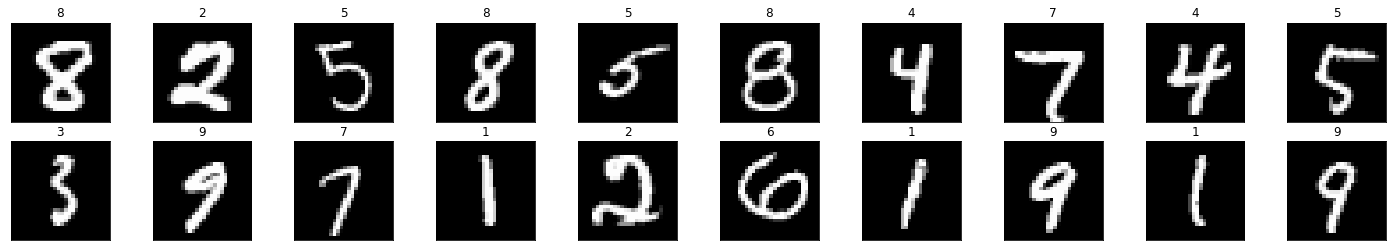

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

## Defining the Neural Network

In [5]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

## Training the Network

In [1]:
n_epochs = 50

# initializing the tracker for min valid loss
valid_loss_min = np.Inf  # set initial 'min' to infinity

for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        op = model(images)
        loss = criterion(op, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()


    model.eval()
    for images, labels in valid_loader:
        op = model(images)
        loss = criterion(op, labels)
        valid_loss += loss.item()
    
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(test_loader)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    
#     save model is validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f}--> {:.6f}).\tSaving model ...\n'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

NameError: name 'np' is not defined

In [8]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Testing the Network
---
Testing out model on previously unseen test data, helps evaluate the model in the most unbiased fashion. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [9]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for images, labels in test_loader:
    op = model(images)
    loss = criterion(op, labels)
    test_loss += loss.item()
    _, pred = torch.max(op, 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
#     print(correct)
    
    for i in range(bs):
        lab = labels.data[i]
        class_correct[lab] += correct[i].item()
        class_total[lab] += 1

test_loss = test_loss/len(test_loader)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.063810

Test Accuracy of     0: 98% (966/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 97% (1007/1032)
Test Accuracy of     3: 98% (990/1010)
Test Accuracy of     4: 98% (964/982)
Test Accuracy of     5: 98% (875/892)
Test Accuracy of     6: 98% (939/958)
Test Accuracy of     7: 97% (1003/1028)
Test Accuracy of     8: 96% (941/974)
Test Accuracy of     9: 97% (984/1009)

Test Accuracy (Overall): 97% (9793/10000)


## Visualize Sample Test Results
---
This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

<ipython-input-10-c066ea460771>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


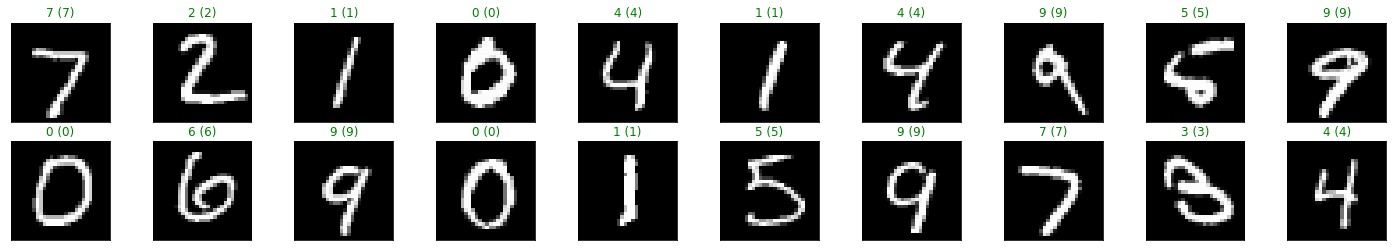

In [10]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))